### Import librairies

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install vaderSentiment
!pip install Afinn
!pip install textBlob

In [2]:
import pandas as pd
import numpy as np
import en_core_web_sm
import nltk
import string 
from textblob import TextBlob
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
from afinn import Afinn
import joblib

pd.options.mode.chained_assignment = None
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import nltk
import string

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.regularizers import l2, l1
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM, Dropout, Bidirectional

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Explore Dataset

In [4]:
df_chatgpt = pd.read_csv("dataset.csv", usecols=[1,2])

print("Number of rows in the dataset")
print(df_chatgpt.shape[0])
print("--------------------")
print("Sample of the dataset")
display(df_chatgpt.head())
print("--------------------")
print("Counting of label values")
display(df_chatgpt.labels.value_counts())

Number of rows in the dataset
219294
--------------------
Sample of the dataset


,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,"Try talking with ChatGPT, our new AI system wh...",good
2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,"THRILLED to share that ChatGPT, our new model ...",good
4,"As of 2 minutes ago, @OpenAI released their ne...",bad


--------------------
Counting of label values


bad        107796
good        56011
neutral     55487
Name: labels, dtype: int64

In [5]:
df_chatgpt = df_chatgpt.reset_index().rename(columns = {'index':'index_origin'})
df_chatgpt.head()

,index_origin,tweets,labels
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,1,"Try talking with ChatGPT, our new AI system wh...",good
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,3,"THRILLED to share that ChatGPT, our new model ...",good
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad


### Preprocessing

#### 1. Preprocessing for Unsupervized models

In [6]:
# Preprocessing function for VADER sentiment analysis

def Clean_ML(data, column):
    # create the cleaned_tweets columns
    new_column = data[column].str \
                       .replace(r"\\n"," ", regex=True) \
                       .apply(lambda x: re.sub(r"http\S+","",str(x))) \
                       .apply(lambda x: re.sub(r'\#chatgpt', 'ChatGPT', str(x), flags=re.IGNORECASE)) \
                       .apply(lambda x: re.sub(r'\#chatbot', 'ChatBOT', str(x), flags=re.IGNORECASE)) \
                       .apply(lambda x: re.sub(r'\#gpt', 'GPT', str(x), flags=re.IGNORECASE)) \
                       .apply(lambda x: re.sub(r'\#gpt3', 'GPT3', str(x), flags=re.IGNORECASE)) \
                       .apply(lambda x: re.sub(r'\@openai', 'OpenAI', str(x), flags=re.IGNORECASE)) \
                       .apply(lambda x: re.sub(r"#\S+","",str(x))) \
                       .apply(lambda x: re.sub(r"@\S+","",str(x))) \
                       .apply(lambda x: x.replace("&amp;","&")) \
                       .apply(lambda x: re.sub(r"\s+", " ", x, flags=re.UNICODE)) 
    return new_column

In [7]:
# Create the cleaned columns
df_chatgpt['cleaned_tweets_labels'] = Clean_ML(df_chatgpt, 'tweets')

# Printing elements
print("Before cleaning : ", df_chatgpt.tweets[2])
print("--------------------")
print("After cleaning : ", df_chatgpt.cleaned_tweets_labels[2])

Before cleaning :  ChatGPT: Optimizing Language Models for Dialogue https://t.co/GLEbMoKN6w #AI #MachineLearning #DataScience #ArtificialIntelligence\n\nTrending AI/ML Article Identified &amp; Digested via Granola; a Machine-Driven RSS Bot by Ramsey Elbasheer https://t.co/RprmAXUp34
--------------------
After cleaning :  ChatGPT: Optimizing Language Models for Dialogue Trending AI/ML Article Identified & Digested via Granola; a Machine-Driven RSS Bot by Ramsey Elbasheer 


In [8]:
df_chatgpt.to_csv("df_chatgpt_clean_ml.csv", header=True)

#### 2. Preprocessing for deep learning models

In [10]:
# Preprocessing function for DL model

def Clean_DL(data, column, stop, nlp):
    # create the cleaned_tweets columns
    new_column = data[column].str.lower() \
                                  .replace(r"\\n"," ", regex=True) \
                                  .apply(lambda x: re.sub(r"http\S+","",str(x))) \
                                  .apply(lambda x : re.sub(r"#\S+","",str(x))) \
                                  .apply(lambda x : re.sub(r"@\S+","",str(x))) \
                                  .apply(lambda x: x.replace("&amp;","&")) \
                                  .apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if \
                                                              (token.lemma_ not in stop) & \
                                                              (token.text not in stop) & \
                                                              (token.lemma_.isalnum())])) \
                                  .apply(lambda x: re.sub(r"\s+", " ", x, flags=re.UNICODE))
    return new_column

In [11]:
# Apply the function
nlp = spacy.load("en_core_web_sm")
stop = stopwords.words('english')

df_chatgpt['cleaned_tweets_dl'] = Clean_DL(df_chatgpt, 'tweets', stop, nlp)#38 min

In [12]:
# Drop duplicates
print("Number of row before dropping duplicates : ", df_chatgpt.shape[0])
df_chatgpt.drop_duplicates(subset=["cleaned_tweets_dl"], inplace=True)
print("--------------------")
print("Number of row after dropping duplicates : ", df_chatgpt.shape[0])

Number of row before dropping duplicates :  219294
--------------------
Number of row after dropping duplicates :  185622


In [13]:
# Export the cleaned dataset
df_chatgpt.to_csv("df_cleaned.csv", header=True)

In [14]:
# Import the dataset 
df_cleaned = pd.read_csv("df_cleaned.csv")

df_cleaned = df_cleaned.loc[:, ~df_cleaned.columns.str.contains('^Unnamed')]
df_cleaned.head()

,index_origin,tweets,labels,cleaned_tweets_labels,cleaned_tweets_dl
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral,ChatGPT: Optimizing Language Models for Dialog...,chatgpt optimize language model dialogue
1,1,"Try talking with ChatGPT, our new AI system wh...",good,"Try talking with ChatGPT, our new AI system wh...",try talk chatgpt new ai system optimize dialog...
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral,ChatGPT: Optimizing Language Models for Dialog...,chatgpt optimize language model dialogue trend...
3,3,"THRILLED to share that ChatGPT, our new model ...",good,"THRILLED to share that ChatGPT, our new model ...",thrilled share chatgpt new model optimize dial...
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad,"As of 2 minutes ago, OpenAI released their new...",2 minute ago release new chatgpt use right


### Unsupervised models

##### Function to get sentiments

In [15]:
def getsentiments(x):
    if x > 0:
        return "Positive"
    elif x < 0 :
        return "Negative"
    else:
        return 'Neutral'

##### 1. VADER model

In [16]:
# VADER
sia = SentimentIntensityAnalyzer()

# Run the polarity score on the entire dataset
res = {}
for i, row in df_chatgpt.iterrows():
    tweet = row['cleaned_tweets_labels']
    id = row['index_origin']
    res[id] = sia.polarity_scores(tweet)

# print the 5 first elements
list(res.items())[:5]

[(0, {'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'compound': 0.4588}),
 (1, {'neg': 0.0, 'neu': 0.664, 'pos': 0.336, 'compound': 0.8225}),
 (2, {'neg': 0.0, 'neu': 0.87, 'pos': 0.13, 'compound': 0.4588}),
 (3, {'neg': 0.0, 'neu': 0.553, 'pos': 0.447, 'compound': 0.9029}),
 (4, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0})]

In [57]:
# Example to show how works VADER 
sia.polarity_scores("VADER is amazing")

{'neg': 0.0, 'neu': 0.345, 'pos': 0.655, 'compound': 0.5859}

In [17]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'index_origin'})
    
df_chatgpt = vaders.merge(df_chatgpt, how='left').drop(columns=['neg','neu','pos'])

df_chatgpt['vader_labels'] = df_chatgpt['compound'].apply(getsentiments)

df_chatgpt.drop(columns=['compound'], axis=1, inplace=True)

df_chatgpt.head()

,index_origin,tweets,labels,cleaned_tweets_labels,cleaned_tweets_dl,vader_labels
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral,ChatGPT: Optimizing Language Models for Dialog...,chatgpt optimize language model dialogue,Positive
1,1,"Try talking with ChatGPT, our new AI system wh...",good,"Try talking with ChatGPT, our new AI system wh...",try talk chatgpt new ai system optimize dialog...,Positive
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral,ChatGPT: Optimizing Language Models for Dialog...,chatgpt optimize language model dialogue trend...,Positive
3,3,"THRILLED to share that ChatGPT, our new model ...",good,"THRILLED to share that ChatGPT, our new model ...",thrilled share chatgpt new model optimize dial...,Positive
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad,"As of 2 minutes ago, OpenAI released their new...",2 minute ago release new chatgpt use right,Neutral


#### 2. AFINN model

In [18]:
df_chatgpt['score'] = df_chatgpt['cleaned_tweets_labels'].apply(lambda x: Afinn().score(x))
df_chatgpt['afinn_labels'] = df_chatgpt['score'].apply(getsentiments)

df_chatgpt.drop(columns=['score'], axis=1, inplace=True)

df_chatgpt.head()

,index_origin,tweets,labels,cleaned_tweets_labels,cleaned_tweets_dl,vader_labels,afinn_labels
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral,ChatGPT: Optimizing Language Models for Dialog...,chatgpt optimize language model dialogue,Positive,Neutral
1,1,"Try talking with ChatGPT, our new AI system wh...",good,"Try talking with ChatGPT, our new AI system wh...",try talk chatgpt new ai system optimize dialog...,Positive,Positive
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral,ChatGPT: Optimizing Language Models for Dialog...,chatgpt optimize language model dialogue trend...,Positive,Neutral
3,3,"THRILLED to share that ChatGPT, our new model ...",good,"THRILLED to share that ChatGPT, our new model ...",thrilled share chatgpt new model optimize dial...,Positive,Positive
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad,"As of 2 minutes ago, OpenAI released their new...",2 minute ago release new chatgpt use right,Neutral,Neutral


#### 3. Text BLOB model

In [19]:
df_chatgpt['score_textblob'] = df_chatgpt['cleaned_tweets_labels'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df_chatgpt['textblob_labels'] = df_chatgpt['score_textblob'].apply(getsentiments)

df_chatgpt.drop(columns=['score_textblob'], axis=1, inplace=True)

df_chatgpt.head()

,index_origin,tweets,labels,cleaned_tweets_labels,cleaned_tweets_dl,vader_labels,afinn_labels,textblob_labels
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral,ChatGPT: Optimizing Language Models for Dialog...,chatgpt optimize language model dialogue,Positive,Neutral,Neutral
1,1,"Try talking with ChatGPT, our new AI system wh...",good,"Try talking with ChatGPT, our new AI system wh...",try talk chatgpt new ai system optimize dialog...,Positive,Positive,Positive
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral,ChatGPT: Optimizing Language Models for Dialog...,chatgpt optimize language model dialogue trend...,Positive,Neutral,Neutral
3,3,"THRILLED to share that ChatGPT, our new model ...",good,"THRILLED to share that ChatGPT, our new model ...",thrilled share chatgpt new model optimize dial...,Positive,Positive,Positive
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad,"As of 2 minutes ago, OpenAI released their new...",2 minute ago release new chatgpt use right,Neutral,Neutral,Positive


In [20]:
# Export data
df_chatgpt.to_csv("df_new_labels.csv", header=True)

In [22]:
# Import data with new labels
df_new_labels = pd.read_csv("/content/df_new_labels.csv",index_col=0 )
# df_new_labels.head()

#### 4. Models

In [23]:
# 2 for good tweet
# 1 for neutral tweet
# 0 for bad tweet

def CharToNumLabels(x):
   if x == 'Positive':
        return 2
   elif x == 'Neutral':
        return 1
   else:
        return 0

def CharToNumLabels2(x):
   if x == 'good':
        return 2
   elif x == 'neutral':
        return 1
   else:
        return 0

df_new_labels['labels_num'] = df_new_labels['labels'].apply(CharToNumLabels2)
df_new_labels['vader_labels_num'] = df_new_labels['vader_labels'].apply(CharToNumLabels)
df_new_labels['afinn_labels_num'] = df_new_labels['afinn_labels'].apply(CharToNumLabels)
df_new_labels['textblob_labels_num'] = df_new_labels['textblob_labels'].apply(CharToNumLabels)

df_new_labels = df_new_labels[df_new_labels.cleaned_tweets_dl.isna()==False]

# df_new_labels.head(10)

#### Multinomial logistic regression

In [24]:
X = df_new_labels.cleaned_tweets_dl
y = df_new_labels.labels_num

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)

In [25]:
logreg = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', LogisticRegression(n_jobs=1, C=1e5, max_iter=1000, solver='newton-cg')),
               ])
logreg.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(C=100000.0, max_iter=1000, n_jobs=1,
                                    solver='newton-cg'))])

In [26]:
y_pred = logreg.predict(X_test)
from sklearn.metrics import classification_report
print('Logistic regression accuracy : %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=df_new_labels.labels.unique().tolist()))

Logistic regression accuracy : 0.7655646739813601
              precision    recall  f1-score   support

     neutral       0.85      0.86      0.85     25720
        good       0.59      0.62      0.60     14404
         bad       0.79      0.75      0.77     15563

    accuracy                           0.77     55687
   macro avg       0.74      0.74      0.74     55687
weighted avg       0.77      0.77      0.77     55687



In [27]:
# Get the predictions on the test set 
df_test = df_new_labels.loc[df_new_labels.index.isin(X_test.index), ['tweets', 'labels']]

df_test['y_pred'] = y_pred

def NumToChar(x):
   if x == 2:
        return 'Positive'
   elif x == 1:
        return 'Neutral'
   else:
        return "Negative"

df_test['pred_labels']=df_test['y_pred'].apply(NumToChar)
df_test

,tweets,labels,y_pred,pred_labels
0,ChatGPT: Optimizing Language Models for Dialog...,neutral,0,Negative
5,"Just launched ChatGPT, our new AI system which...",good,0,Negative
12,OpenAI ChatGPT: Optimizing Language Models for...,neutral,1,Neutral
16,"Just launched ChatGPT, our conversational AI s...",good,2,Positive
17,OpenAI ChatGPT: Optimizing Language Models for...,neutral,0,Negative
...,...,...,...,...
185598,5p @ReneeInspired sent me this since I have be...,neutral,0,Negative
185601,If you need another reason to join the free al...,good,0,Negative
185603,I was hoping ChatGPT would mention stem cell t...,neutral,0,Negative
185613,ChatGPT is banned on Stack Overflow until furt...,bad,0,Negative


### Deep Learning models from scratch

#### A. LSTM with final labels

##### Map the labels to integer

##### Tonkenization

In [29]:
# Instanciate the tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000) # keep only the most common 10 000 tokens

# Fit on our data
df_new_labels["cleaned_tweets_dl"] = df_new_labels["cleaned_tweets_dl"].apply(lambda x: str(x))
tokenizer.fit_on_texts(df_new_labels["cleaned_tweets_dl"])

# Transform text to sequences
df_new_labels["tweets_encoded"] = tokenizer.texts_to_sequences(df_new_labels.cleaned_tweets_dl)

# Determine the length of each tweet and keep only not emty tweets after preprocessing
df_new_labels["len_tweets"] = df_new_labels["tweets_encoded"].apply(lambda x: len(x))
df_new_labels = df_new_labels[df_new_labels["len_tweets"]!=0]

df_new_labels.head()

,index_origin,tweets,labels,cleaned_tweets_labels,cleaned_tweets_dl,vader_labels,afinn_labels,textblob_labels,labels_num,vader_labels_num,afinn_labels_num,textblob_labels_num,tweets_encoded,len_tweets
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral,ChatGPT: Optimizing Language Models for Dialog...,chatgpt optimize language model dialogue,Positive,Neutral,Neutral,1,2,1,1,"[1, 877, 50, 41, 598]",5
1,1,"Try talking with ChatGPT, our new AI system wh...",good,"Try talking with ChatGPT, our new AI system wh...",try talk chatgpt new ai system optimize dialog...,Positive,Positive,Positive,2,2,2,2,"[20, 63, 1, 10, 2, 164, 877, 598, 568, 40, 272]",11
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral,ChatGPT: Optimizing Language Models for Dialog...,chatgpt optimize language model dialogue trend...,Positive,Neutral,Neutral,1,2,1,1,"[1, 877, 50, 41, 598, 331, 2, 626, 85, 704, 14...",19
3,3,"THRILLED to share that ChatGPT, our new model ...",good,"THRILLED to share that ChatGPT, our new model ...",thrilled share chatgpt new model optimize dial...,Positive,Positive,Positive,2,2,2,2,"[4901, 195, 1, 10, 41, 877, 2175, 486, 152, 14...",11
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad,"As of 2 minutes ago, OpenAI released their new...",2 minute ago release new chatgpt use right,Neutral,Neutral,Positive,0,1,1,2,"[97, 293, 404, 167, 10, 1, 3, 76]",8


In [30]:
df_new_labels["len_tweets"] = df_new_labels["tweets_encoded"].apply(lambda x: len(x))
df_new_labels = df_new_labels[df_new_labels["len_tweets"]!=0]
print(df_new_labels.shape[0])

185413


##### Padding

In [31]:
df_new_labels_pad = tf.keras.preprocessing.sequence.pad_sequences(df_new_labels.tweets_encoded, padding="post")

In [32]:
full_ds = tf.data.Dataset.from_tensor_slices((df_new_labels_pad, df_new_labels['labels_num'].values))

In [33]:
TAKE_SIZE = int(0.7*df_new_labels.shape[0])

train_data = full_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(64)

test_data = full_ds.skip(TAKE_SIZE)
test_data = test_data.batch(64)

In [34]:
for tweets, labels in train_data.take(1):
  print(tweets, labels)

tf.Tensor(
[[   1 1286 3005 ...    0    0    0]
 [  30    4 1693 ...    0    0    0]
 [  42   31 7412 ...    0    0    0]
 ...
 [  87  889    1 ...    0    0    0]
 [   5    4 8037 ...    0    0    0]
 [1314    1   15 ...    0    0    0]], shape=(64, 48), dtype=int32) tf.Tensor(
[2 0 0 1 0 1 2 2 0 1 0 2 1 1 1 2 2 0 0 0 2 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 2
 1 0 0 0 2 2 0 1 2 0 2 0 0 1 1 2 1 1 1 2 2 0 1 2 0 0 0], shape=(64,), dtype=int64)


In [35]:
weights = 1/(df_new_labels["labels_num"]).value_counts()
weights = weights * len(df_new_labels) /3
weights = {index : values for index , values in zip(weights.index,weights.values)}
weights

{0: 0.7206157840325226, 2: 1.1932029525519494, 1: 1.2916266109369559}

In [51]:
vocab_size = len(tokenizer.word_index)
model_lstm = tf.keras.Sequential([
                  Embedding(vocab_size+1, 64, input_shape=[tweets.shape[1],],name="embedding"),
                  LSTM(units=32, return_sequences=True), 
                  LSTM(units=32, return_sequences=False),
                  Dense(8, activation='relu'), 
                  Dense(3, activation="softmax", name="last")
])

In [52]:
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 48, 64)            3404928   
                                                                 
 lstm_1 (LSTM)               (None, 48, 32)            12416     
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 8)                 264       
                                                                 
 last (Dense)                (None, 3)                 27        
                                                                 
Total params: 3,425,955
Trainable params: 3,425,955
Non-trainable params: 0
_________________________________________________________________


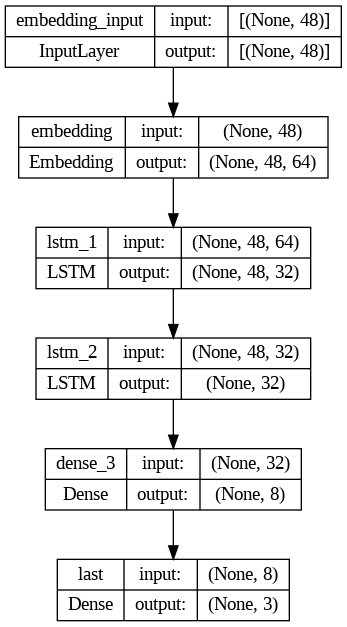

In [53]:
tf.keras.utils.plot_model(model_lstm, show_shapes=True)

In [54]:
optimizer = tf.keras.optimizers.Adam(0.00001)

model_lstm.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [55]:
model_lstm.fit(train_data,
              epochs=10, 
              validation_data=test_data,
               class_weight=weights)

Epoch 1/10
2028/2028 [==============================] - 57s 26ms/step - loss: 1.0967 - sparse_categorical_accuracy: 0.4341 - val_loss: 1.0977 - val_sparse_categorical_accuracy: 0.4544
Epoch 2/10
2028/2028 [==============================] - 24s 12ms/step - loss: 1.0952 - sparse_categorical_accuracy: 0.4366 - val_loss: 1.0873 - val_sparse_categorical_accuracy: 0.3580
Epoch 3/10
2028/2028 [==============================] - 24s 11ms/step - loss: 0.9381 - sparse_categorical_accuracy: 0.5600 - val_loss: 0.7653 - val_sparse_categorical_accuracy: 0.6789
Epoch 4/10
2028/2028 [==============================] - 22s 11ms/step - loss: 0.6794 - sparse_categorical_accuracy: 0.7372 - val_loss: 0.6172 - val_sparse_categorical_accuracy: 0.7574
Epoch 5/10
2028/2028 [==============================] - 23s 11ms/step - loss: 0.5591 - sparse_categorical_accuracy: 0.8004 - val_loss: 0.5358 - val_sparse_categorical_accuracy: 0.7974
Epoch 6/10
2028/2028 [==============================] - 23s 11ms/step - loss: 0.

In [41]:
# Save the model
model_lstm.save("model_lstm.h5")

In [42]:
# Plot the loss evolution for the train and validation set

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=model_lstm.history.history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=model_lstm.history.history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.show()

#### B. GRU

In [47]:
model_gru = tf.keras.Sequential([
                  Embedding(vocab_size+1, 64, input_shape=[tweets.shape[1],],name="embedding"),
                  GRU(units=64, return_sequences=True), 
                  GRU(units=32, return_sequences=False),
                  Dense(16, activation='relu'),
                  Dense(3, activation="softmax")
])

In [48]:
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 48, 64)            3404928   
                                                                 
 gru_1 (GRU)                 (None, 48, 64)            24960     
                                                                 
 gru_2 (GRU)                 (None, 32)                9408      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                                                                 
Total params: 3,439,875
Trainable params: 3,439,875
Non-trainable params: 0
_________________________________________________________________


In [49]:
optimizer= tf.keras.optimizers.Adam()

model_gru.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [50]:
model_gru.fit(train_data,
              epochs=10, 
              validation_data=test_data,
              class_weight=weights)

Epoch 1/10
2028/2028 [==============================] - 60s 28ms/step - loss: 1.0968 - sparse_categorical_accuracy: 0.4114 - val_loss: 1.0977 - val_sparse_categorical_accuracy: 0.4544
Epoch 2/10
2028/2028 [==============================] - 24s 12ms/step - loss: 1.0967 - sparse_categorical_accuracy: 0.3870 - val_loss: 1.0984 - val_sparse_categorical_accuracy: 0.4544
Epoch 3/10
2028/2028 [==============================] - 24s 12ms/step - loss: 1.0967 - sparse_categorical_accuracy: 0.4014 - val_loss: 1.0977 - val_sparse_categorical_accuracy: 0.4544
Epoch 4/10
2028/2028 [==============================] - 24s 12ms/step - loss: 1.0967 - sparse_categorical_accuracy: 0.3988 - val_loss: 1.0977 - val_sparse_categorical_accuracy: 0.4544
Epoch 5/10
2028/2028 [==============================] - 31s 15ms/step - loss: 1.0967 - sparse_categorical_accuracy: 0.4287 - val_loss: 1.0976 - val_sparse_categorical_accuracy: 0.4544
Epoch 6/10
2028/2028 [==============================] - 22s 11ms/step - loss: 1.